This time we are helping out Unicorn Investors with our data hacking skills. They are considering making an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! While JetRail has mastered the technology and they hold the patent for their product, the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months.
 
We need to help Unicorn ventures with the decision. They usually invest in B2C start-ups less than 4 years old looking for pre-series A funding. In order to help Unicorn Ventures in their decision, we need to forecast the traffic on JetRail for the next 7 months. We are provided with traffic data of JetRail since inception in the train/test file.

In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib.cm as cm
from matplotlib.colors import Normalize
from numpy.random import rand
import statsmodels.api as sm

from pylab import rcParams
rcParams['figure.figsize'] = 10,5

import warnings # to ignore the warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SARIMAX

## INITIAL ANALYSIS

In [2]:
def parser(x):
    return datetime.strptime(x,'%d-%m-%Y %H:%M')

train=pd.read_csv("Train_Jetrail.csv", parse_dates= ['Datetime'], date_parser=parser) 
test=pd.read_csv("Test_Jetrail.csv", parse_dates= ['Datetime'], date_parser=parser )

In [3]:
train.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
ID          18288 non-null int64
Datetime    18288 non-null datetime64[ns]
Count       18288 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 428.8 KB


In [5]:
df=train.copy()
df['year']= df.Datetime.dt.year
df['month']= df.Datetime.dt.month
df['day']= df.Datetime.dt.day
df['hour']= df.Datetime.dt.hour
df['dow']= df.Datetime.dt.dayofweek
df['weekend']= df['dow'].apply(lambda x: 1 if x==5 or x==6 else 0)
train=df.copy()

df=test.copy()
df['year']= df.Datetime.dt.year
df['month']= df.Datetime.dt.month
df['day']= df.Datetime.dt.day
df['hour']= df.Datetime.dt.hour
df['dow']= df.Datetime.dt.dayofweek
df['weekend']= df['dow'].apply(lambda x: 1 if x==5 or x==6 else 0)
test=df.copy()

In [6]:
train

,ID,Datetime,Count,year,month,day,hour,dow,weekend
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1
...,...,...,...,...,...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3,0
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3,0
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3,0
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3,0


In [7]:
train_copy=train.copy()
test_copy=test.copy()

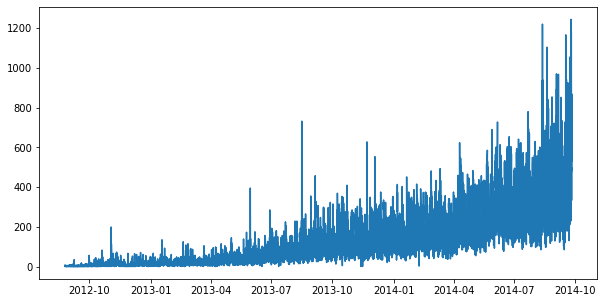

In [8]:
train.drop(['ID'], axis=1, inplace=True)

train.set_index('Datetime', inplace=True)
test.set_index('Datetime', inplace=True)

plt.plot(train.Count)

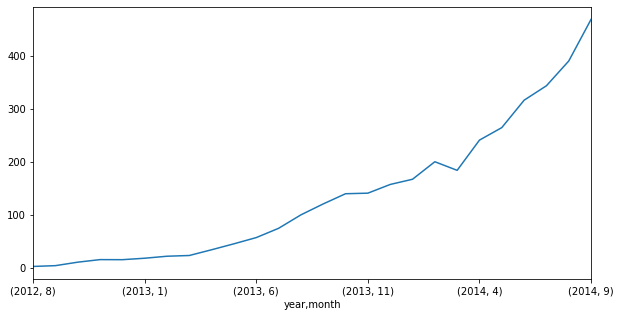

In [9]:
train.groupby(['year','month'])['Count'].mean().plot()

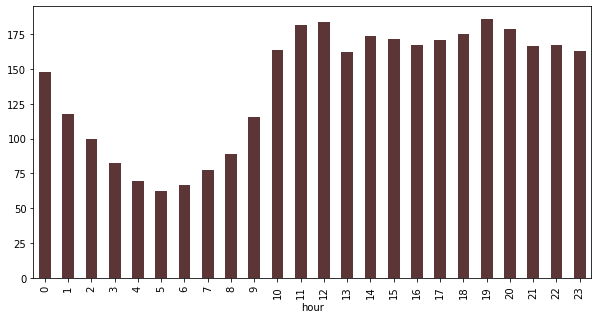

In [10]:
train.groupby(['hour'])['Count'].mean().plot(kind='bar',color= (np.random.random_sample(), np.random.random_sample(), np.random.random_sample()) )

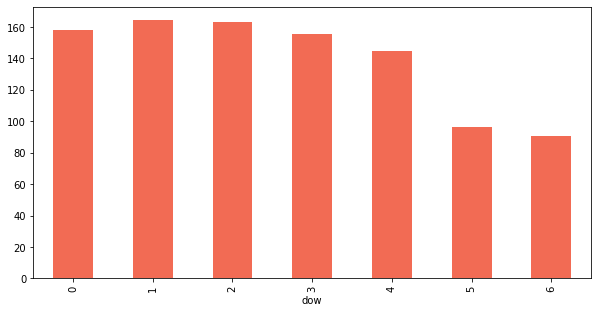

In [11]:
train.groupby(['dow'])['Count'].mean().plot(kind="bar",color= (np.random.random_sample(), np.random.random_sample(), np.random.random_sample()))

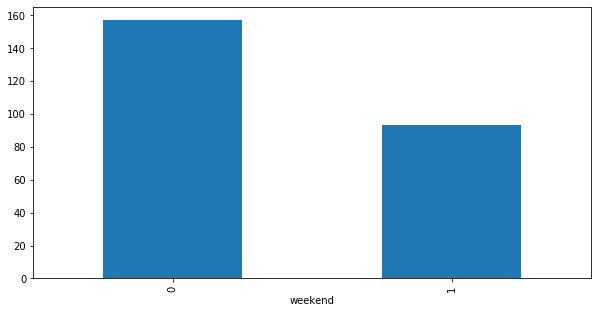

In [12]:
train.groupby('weekend')['Count'].mean().plot(kind='bar')

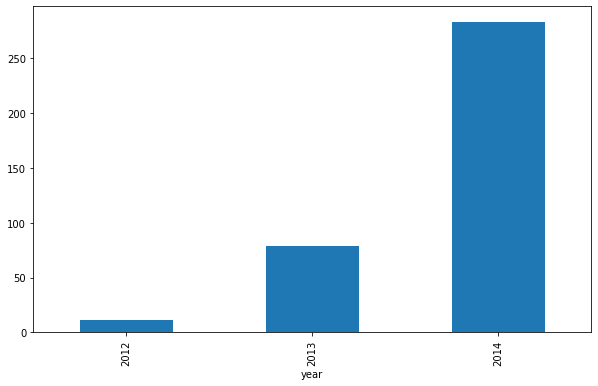

In [13]:


plt.figure(figsize=(10,6))
train.groupby('year')['Count'].mean().plot(kind='bar')


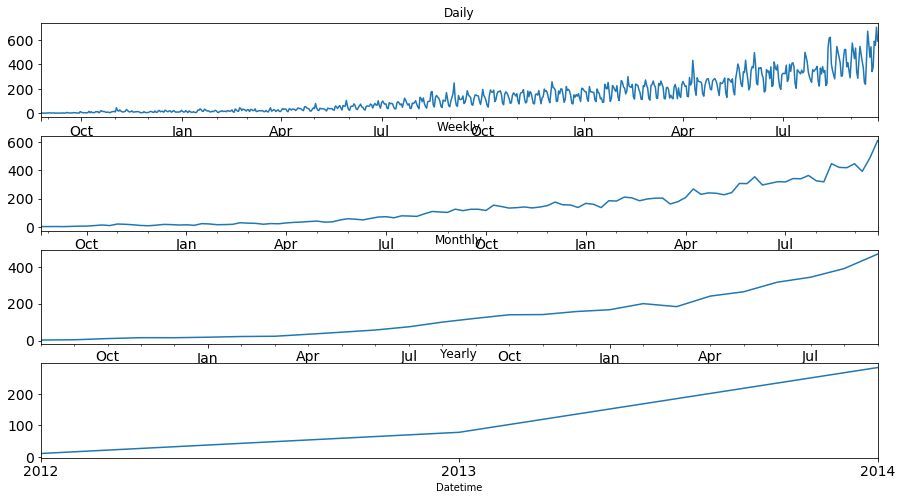

<Figure size 720x432 with 0 Axes>

In [14]:
# Hourly time series 
yearly = train.resample('Y').mean() 
# Converting to daily mean 
daily = train.resample('D').mean() 
# Converting to weekly mean 
weekly = train.resample('W').mean() 
# Converting to monthly mean 
monthly = train.resample('M').mean()

fig, axs = plt.subplots(4,1) 

plt.figure(figsize=(10,6))
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[0])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[1])
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[2]) 
yearly.Count.plot(figsize=(15,8), title= 'Yearly', fontsize=14, ax=axs[3])

plt.show()

# Resampling Data

In [15]:
train = train.resample('D').mean()

In [16]:
test=test.resample("D").mean()

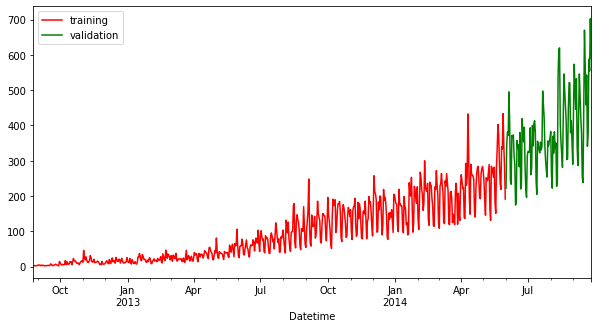

In [17]:
training= train.loc['2012-08':'2014-05']
validation= train.loc['2014-06':'2014-09']

plt.figure(figsize=(10,5))
training.Count.plot(color='red', label= 'training')
validation.Count.plot(color='green', label= 'validation')
plt.legend()
plt.show()

# Modelling Techniques for Time Series Analysis

### 1. MOVING AVERAGE TECHNIQUE

Smoothing is a technique applied to time series to remove the fine-grained variation between time steps.

The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes. Moving averages are a simple and common type of smoothing used in time series analysis and time series forecasting.

Calculating a moving average involves creating a new series where the values are comprised of the average of raw observations in the original time series.

A moving average requires that you specify a window size called the window width. This defines the number of raw observations used to calculate the moving average value.

The “moving” part in the moving average refers to the fact that the window defined by the window width is slid along the time series to calculate the average values in the new series.

In [18]:
train

,Count,year,month,day,hour,dow,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0
...,...,...,...,...,...,...,...
2014-09-21,379.250000,2014.0,9.0,21.0,11.5,6.0,1.0
2014-09-22,588.166667,2014.0,9.0,22.0,11.5,0.0,0.0
2014-09-23,554.333333,2014.0,9.0,23.0,11.5,1.0,0.0


In [19]:
df=validation.copy()

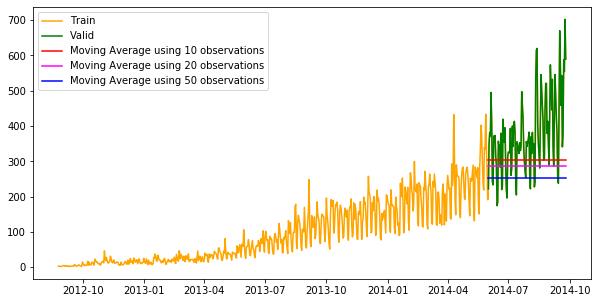

In [20]:
df["moving_avg"]=training.Count.rolling(10).mean().iloc[-1]
df["moving_avg1"]=training.Count.rolling(20).mean().iloc[-1]
df["moving_avg2"]=training.Count.rolling(50).mean().iloc[-1]
plt.plot(train['Count'], label='Train',color="orange") 
plt.plot(validation['Count'], label='Valid',color="green") 

plt.plot(df['moving_avg'], label='Moving Average using 10 observations',color="red")
plt.plot(df['moving_avg1'], label='Moving Average using 20 observations',color="magenta")
plt.plot(df['moving_avg2'], label='Moving Average using 50 observations',color="blue")

plt.legend(loc='best') 
plt.show()

In [21]:
rmse= np.sqrt(mean_squared_error(validation.Count,df['moving_avg']))
print ("RMSE WITH LAST 10 OBSERVATIONS MOVING AVERAGE")
rmse

RMSE WITH LAST 10 OBSERVATIONS MOVING AVERAGE


129.62278554302316

In [22]:
rmse= np.sqrt(mean_squared_error(validation.Count,df['moving_avg1']))
print ("RMSE WITH LAST 20 OBSERVATIONS MOVING AVERAGE")
rmse

RMSE WITH LAST 20 OBSERVATIONS MOVING AVERAGE


139.08836003244812

In [23]:
rmse= np.sqrt(mean_squared_error(validation.Count,df['moving_avg2']))
print ("RMSE WITH LAST 50 OBSERVATIONS MOVING AVERAGE")
rmse

RMSE WITH LAST 50 OBSERVATIONS MOVING AVERAGE


163.30309454351485

### 2. SIMPLE EXPONENTIAL SMOOTHING TECHNIQUE

The mechanics of exponential smoothing work as follows. For a given time period t, you find the smoothed value of a series by computing:
\
\
Smoothed value at time t =St=d×St−1+(1–d)×xt\
Think about how this propagates over time. The smoothed value at time (t – 1) is itself a product of the same thing:

St−1=d×St−2+(1–d)×xt−1\
So we can see a more complex expression for the smoothed value at time t:\
\
d×(d×St–2+(1–d)×xt−1)+(1−d)×xt\
Mathematically inclined readers will notice that we have a series of the form:

d3×xt−3+d2×xt−2+d×xt−1

It requires a single parameter, called alpha (a), also called the smoothing factor or smoothing coefficient.

This parameter controls the rate at which the influence of the observations at prior time steps decay exponentially. \
Alpha is often set to a value between 0 and 1. Large values mean that the model pays attention mainly to the most recent past observations, whereas smaller values mean more of the history is taken into account when making a prediction

In [24]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

Here we run three variants of simple exponential smoothing: 1. In fit1 we do not use the auto optimization but instead choose to explicitly provide the model with the α=0.2 parameter 2. In fit2 as above we choose an α=0.6 3. In fit3 we allow statsmodels to automatically find an optimized α value for us. This is the recommended approach.

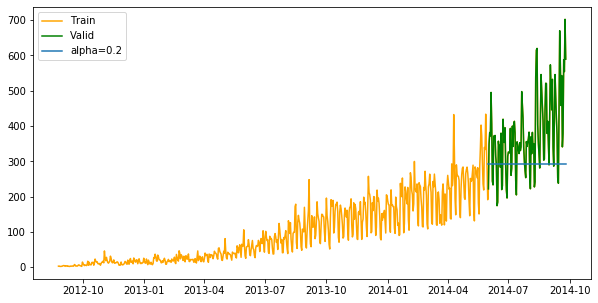

In [25]:
fit1 = SimpleExpSmoothing(training.Count).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(len(validation)).rename(r'$\alpha=0.2$')
# plot
plt.plot(train['Count'], label='Train',color="orange") 
plt.plot(validation['Count'], label='Valid',color="green") 
plt.plot(fcast1, label='alpha=0.2') 
plt.legend(loc='best') 

In [26]:
rmse= np.sqrt(mean_squared_error(validation.Count,fcast1))
rmse

136.4388838133983

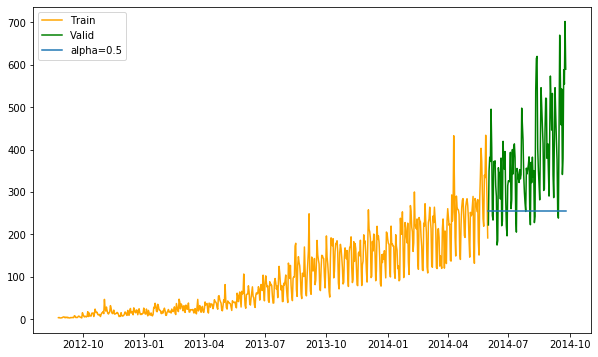

In [27]:
fit2 = SimpleExpSmoothing(training.Count).fit(smoothing_level=0.5,optimized=False)
fcast2 = fit2.forecast(len(validation)).rename(r'$\alpha=0.5$')
# plot

plt.figure(figsize=(10,6))
plt.plot(training['Count'], label='Train',color="orange") 
plt.plot(validation['Count'], label='Valid',color="green") 
plt.plot(fcast2, label='alpha=0.5') 
plt.legend(loc='best') 

In [28]:
rmse= np.sqrt(mean_squared_error(validation.Count,fcast2))
rmse

161.97307798123828

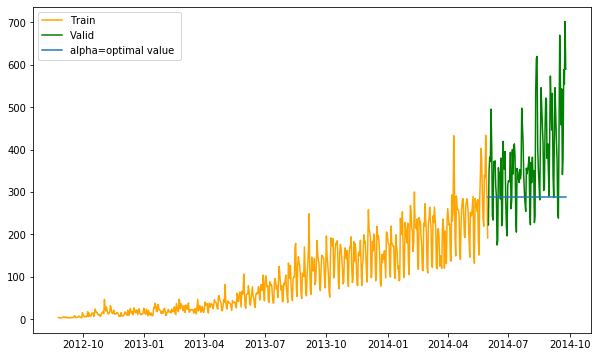

In [29]:
fit3 = SimpleExpSmoothing(training.Count).fit()
fcast3 = fit3.forecast(len(validation)).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])

plt.figure(figsize=(10,6))
plt.plot(training['Count'], label='Train',color="orange") 
plt.plot(validation['Count'], label='Valid',color="green") 
plt.plot(fcast3, label='alpha=optimal value ') 
plt.legend(loc='best') 

In [30]:
rmse= np.sqrt(mean_squared_error(validation.Count,fcast3))
rmse

139.33401499232494

### 3. Holt’s Linear Trend Model

The idea behind Double Exponential Smoothing (a.k.a the Holt Method) is exponential smoothing applied to both level and trend. The basic idea is saying if our time series has a trend, we can incorporate that information to do better than just estimating the current level and using that to forecast the future observations. 
\
In addition to the alpha parameter for controlling smoothing factor for the level, an additional smoothing factor is added to control the decay of the influence of the change in trend called beta (b).

The method supports trends that change in different ways: an additive and a multiplicative, depending on whether the trend is linear or exponential respectively.

Double Exponential Smoothing with an additive trend is classically referred to as Holt’s linear trend model, named for the developer of the method Charles Holt.
\
Additive Trend: Double Exponential Smoothing with a linear trend.\
Multiplicative Trend: Double Exponential Smoothing with an exponential trend.\
For longer range (multi-step) forecasts, the trend may continue on unrealistically. As such, it can be useful to dampen the trend over time.


Dampening means reducing the size of the trend over future time steps down to a straight line (no trend).\

As with modeling the trend itself, we can use the same principles in dampening the trend, specifically additively or multiplicatively for a linear or exponential dampening effect. A damping coefficient Phi (p) is used to control the rate of dampening.

\
Additive Dampening: Dampen a trend linearly.\
Multiplicative Dampening: Dampen the trend exponentially.\
Hyperparameters:

\
Alpha: Smoothing factor for the level.\
Beta: Smoothing factor for the trend.\
Trend Type: Additive or multiplicative.\
Dampen Type: Additive or multiplicative.\
Phi: Damping coefficient.

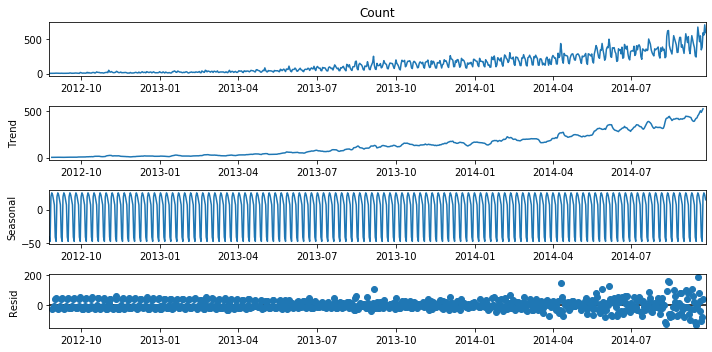

In [31]:
decomposition = sm.tsa.seasonal_decompose(train["Count"], model='additive')
fig = decomposition.plot()

plt.show()

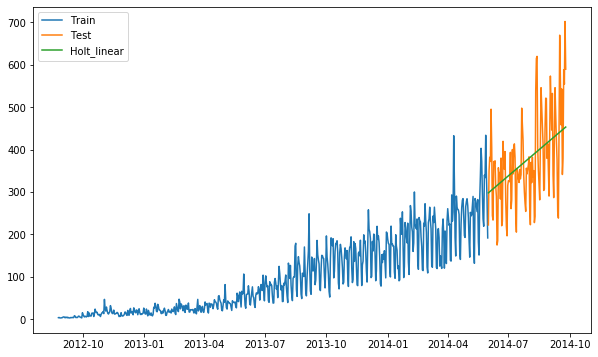

In [32]:
fit1 = Holt(training['Count']).fit(smoothing_level = 0.1,smoothing_slope = 0.02,optimized=False)
fcast1 = fit1.forecast(len(validation))

plt.figure(figsize=(10,6))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Test')
plt.plot(fcast1, label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [33]:
rms = np.sqrt(mean_squared_error(validation.Count,fcast1 ))
print(rms)

94.15601874886597


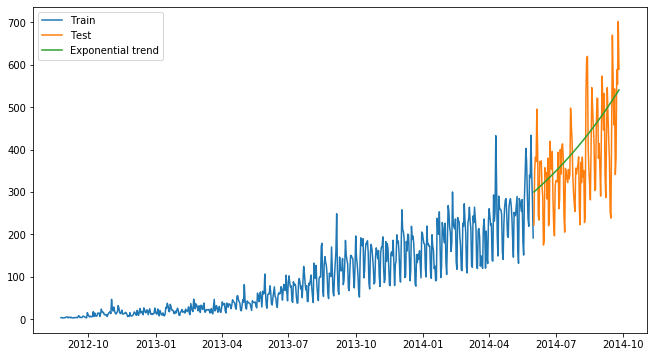

In [34]:

fit2 = Holt(training.Count, exponential=True).fit(smoothing_level=0.1, smoothing_slope=0.01, optimized=False)
fcast2 = fit2.forecast(len(validation)).rename("Exponential trend")

plt.figure(figsize=(11,6))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Test')
plt.plot(fcast2, label='Exponential trend')
plt.legend(loc='best')
plt.show()

In [35]:
rms = np.sqrt(mean_squared_error(validation.Count,fcast2 ))
print(rms)

99.52735094966117


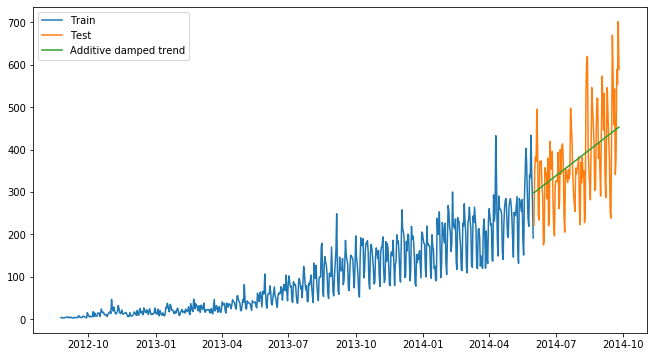

In [36]:

fit3 = Holt(training.Count, damped=True).fit(smoothing_level=0.1, smoothing_slope=0.02)
fcast3 = fit3.forecast(len(validation)).rename("Additive damped trend")

plt.figure(figsize=(11,6))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Test')
plt.plot(fcast3, label='Additive damped trend')
plt.legend(loc='best')
plt.show()

In [37]:
rms = np.sqrt(mean_squared_error(validation.Count,fcast3 ))
print(rms)

94.15601879862905


Given the RMSE of first model is less, we will go with that.

In [38]:
test["Count_predicted"]=fit1.predict(start="2014-9-26", end="2015-4-26")

In [39]:
test.head()

,ID,year,month,day,hour,dow,weekend,Count_predicted
Datetime,,,,,,,,
2014-09-26,18299.5,2014.0,9.0,26.0,11.5,4.0,0.0,454.432482
2014-09-27,18323.5,2014.0,9.0,27.0,11.5,5.0,1.0,455.771251
2014-09-28,18347.5,2014.0,9.0,28.0,11.5,6.0,1.0,457.110020
2014-09-29,18371.5,2014.0,9.0,29.0,11.5,0.0,0.0,458.448789
2014-09-30,18395.5,2014.0,9.0,30.0,11.5,1.0,0.0,459.787558



Remember this is the daily predictions. We have to convert these predictions to hourly basis. To do so we will first calculate the ratio of passenger count for each hour of every day. Then we will find the average ratio of passenger count for every hour and we will get 24 ratios. * Then to calculate the hourly predictions we will multiply the daily prediction with the hourly ratio

In [40]:
test_copy

,ID,Datetime,year,month,day,hour,dow,weekend
0,18288,2014-09-26 00:00:00,2014,9,26,0,4,0
1,18289,2014-09-26 01:00:00,2014,9,26,1,4,0
2,18290,2014-09-26 02:00:00,2014,9,26,2,4,0
3,18291,2014-09-26 03:00:00,2014,9,26,3,4,0
4,18292,2014-09-26 04:00:00,2014,9,26,4,4,0
...,...,...,...,...,...,...,...,...
5107,23395,2015-04-26 19:00:00,2015,4,26,19,6,1
5108,23396,2015-04-26 20:00:00,2015,4,26,20,6,1
5109,23397,2015-04-26 21:00:00,2015,4,26,21,6,1
5110,23398,2015-04-26 22:00:00,2015,4,26,22,6,1


In [41]:
train_copy['ratio']=train_copy['Count']/train_copy['Count'].sum()

In [42]:
train_copy

,ID,Datetime,Count,year,month,day,hour,dow,weekend,ratio
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1,3.148037e-06
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1,7.870093e-07
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1,2.361028e-06
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1,7.870093e-07
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1,7.870093e-07
...,...,...,...,...,...,...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3,0,3.415620e-04
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3,0,2.880454e-04
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3,0,2.762403e-04
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3,0,2.282327e-04


In [43]:
train_ratio=pd.DataFrame(train_copy.groupby("hour")["ratio"].sum())

In [44]:
test.drop("ID",inplace=True,axis=1)

In [45]:
test

,year,month,day,hour,dow,weekend,Count_predicted
Datetime,,,,,,,
2014-09-26,2014.0,9.0,26.0,11.5,4.0,0.0,454.432482
2014-09-27,2014.0,9.0,27.0,11.5,5.0,1.0,455.771251
2014-09-28,2014.0,9.0,28.0,11.5,6.0,1.0,457.110020
2014-09-29,2014.0,9.0,29.0,11.5,0.0,0.0,458.448789
2014-09-30,2014.0,9.0,30.0,11.5,1.0,0.0,459.787558
...,...,...,...,...,...,...,...
2015-04-22,2015.0,4.0,22.0,11.5,2.0,0.0,732.896431
2015-04-23,2015.0,4.0,23.0,11.5,3.0,0.0,734.235200
2015-04-24,2015.0,4.0,24.0,11.5,4.0,0.0,735.573969


In [46]:
test_copy

,ID,Datetime,year,month,day,hour,dow,weekend
0,18288,2014-09-26 00:00:00,2014,9,26,0,4,0
1,18289,2014-09-26 01:00:00,2014,9,26,1,4,0
2,18290,2014-09-26 02:00:00,2014,9,26,2,4,0
3,18291,2014-09-26 03:00:00,2014,9,26,3,4,0
4,18292,2014-09-26 04:00:00,2014,9,26,4,4,0
...,...,...,...,...,...,...,...,...
5107,23395,2015-04-26 19:00:00,2015,4,26,19,6,1
5108,23396,2015-04-26 20:00:00,2015,4,26,20,6,1
5109,23397,2015-04-26 21:00:00,2015,4,26,21,6,1
5110,23398,2015-04-26 22:00:00,2015,4,26,22,6,1


In [47]:
test=test.merge(test_copy,on=['day','month', 'year'],how="left")

In [48]:
test.drop(["hour_x","dow_x","weekend_x"],axis=1,inplace=True)

In [49]:
test=test.merge(train_ratio,left_on="hour_y",right_index=True,how="left")

In [50]:
test.head()

,year,month,day,Count_predicted,ID,Datetime,hour_y,dow_y,weekend_y,ratio
0,2014.0,9.0,26.0,454.432482,18288,2014-09-26 00:00:00,0,4,0,0.044287
1,2014.0,9.0,26.0,454.432482,18289,2014-09-26 01:00:00,1,4,0,0.035343
2,2014.0,9.0,26.0,454.432482,18290,2014-09-26 02:00:00,2,4,0,0.029911
3,2014.0,9.0,26.0,454.432482,18291,2014-09-26 03:00:00,3,4,0,0.024714
4,2014.0,9.0,26.0,454.432482,18292,2014-09-26 04:00:00,4,4,0,0.020802


In [51]:
test["final_count"]=test["Count_predicted"]*test["ratio"]*24

In [52]:
test=test.drop(['ID', 'day','dow_y','hour_y', 'ratio',"year","month","Count_predicted","dow_y","weekend_y"],axis=1).set_index("Datetime")

In [53]:
test.iloc[2300:2315,:]

,final_count
Datetime,
2014-12-30 20:00:00,746.169641
2014-12-30 21:00:00,696.470406
2014-12-30 22:00:00,698.997113
2014-12-30 23:00:00,682.474644
2014-12-31 00:00:00,619.609369
2014-12-31 01:00:00,494.480692
2014-12-31 02:00:00,418.482970
2014-12-31 03:00:00,345.777527
2014-12-31 04:00:00,291.041989


### 4. Holt’s Winter Model

Holt-Winters’ Method is suitable for data with trends and seasonalities which includes a seasonality smoothing parameter γ. There are two variations to this method:\
Additive method: the seasonal variations are roughly constant through the series.\
Multiplicative method: the seasonal variations are changing proportionally to the level of the series.

In addition to the alpha and beta smoothing factors, a new parameter is added called gamma (g) that controls the influence on the seasonal component.

As with the trend, the seasonality may be modeled as either an additive or multiplicative process for a linear or exponential change in the seasonality.

Additionally, to ensure that the seasonality is modeled correctly, the number of time steps in a seasonal period (Period) must be specified. For example, if the series was monthly data and the seasonal period repeated each year, then the Period=12.
\
Hyperparameters:

Alpha: Smoothing factor for the level.\
Beta: Smoothing factor for the trend.\
Gamma: Smoothing factor for the seasonality.\
Trend Type: Additive or multiplicative.\
Dampen Type: Additive or multiplicative.\
Phi: Damping coefficient.\
Seasonality Type: Additive or multiplicative.\
Period: Time steps in seasonal period.

In [54]:
fit1 = ExponentialSmoothing(training.Count, seasonal_periods=7, trend='add', seasonal='add').fit(use_boxcox=True)
fcast1= fit1.forecast(len(validation.Count))

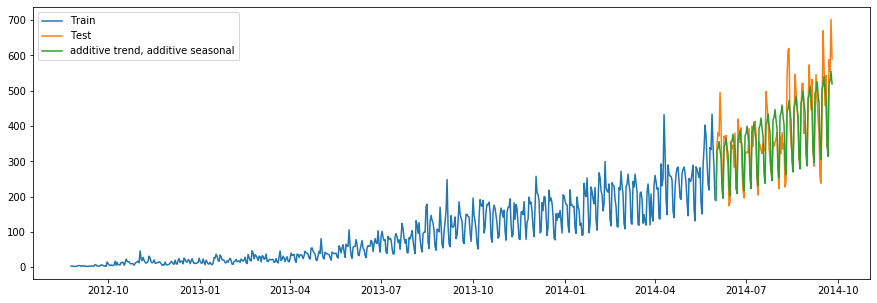

In [55]:
plt.figure(figsize=(15,5))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Test')
plt.plot(fcast1, label='additive trend, additive seasonal')
plt.legend(loc='best')
plt.show()

In [56]:
rmse= np.sqrt(mean_squared_error(validation.Count,fcast1))
rmse

59.676996737106506

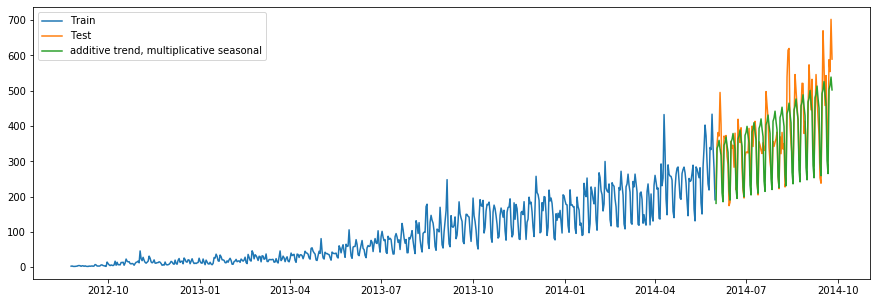

In [57]:
fit2 = ExponentialSmoothing(training.Count, seasonal_periods=7, trend='add', seasonal='mul').fit(use_boxcox=True)
fcast2= fit2.forecast(len(validation.Count))

plt.figure(figsize=(15,5))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Test')
plt.plot(fcast2, label='additive trend, multiplicative seasonal')
plt.legend(loc='best')
plt.show()

In [58]:
rmse= np.sqrt(mean_squared_error(validation.Count,fcast2))
rmse

61.941371179455395

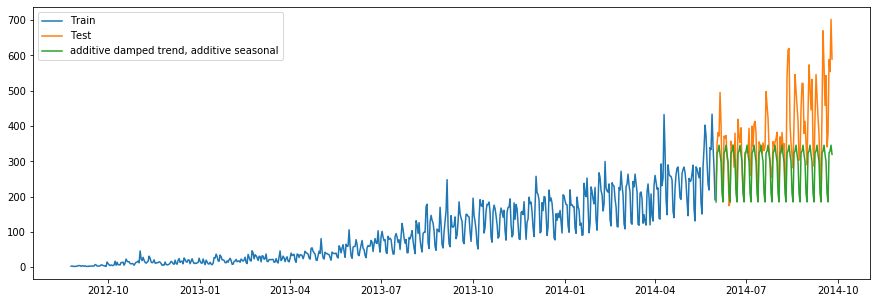

In [59]:
fit3 = ExponentialSmoothing(training.Count, seasonal_periods=7, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fcast3= fit3.forecast(len(validation.Count))

plt.figure(figsize=(15,5))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Test')
plt.plot(fcast3, label='additive damped trend, additive seasonal')
plt.legend(loc='best')
plt.show()

In [60]:
rmse= np.sqrt(mean_squared_error(validation.Count,fcast3))
rmse

120.27520876371433

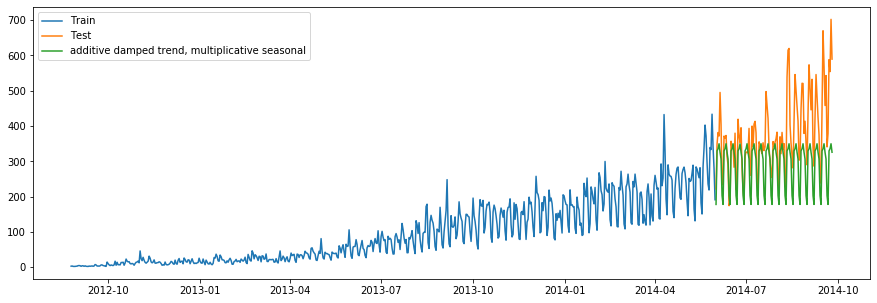

In [61]:
fit4 = ExponentialSmoothing(training.Count, seasonal_periods=7, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
fcast4= fit4.forecast(len(validation.Count))

plt.figure(figsize=(15,5))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Test')
plt.plot(fcast4, label='additive damped trend, multiplicative seasonal')
plt.legend(loc='best')
plt.show()

In [62]:
rmse= np.sqrt(mean_squared_error(validation.Count,fcast4))
rmse

118.05250670105738

In [63]:
test=test_copy.drop("ID",axis=1).set_index("Datetime").resample("D").mean()

In [64]:
test

,year,month,day,hour,dow,weekend
Datetime,,,,,,
2014-09-26,2014.0,9.0,26.0,11.5,4.0,0.0
2014-09-27,2014.0,9.0,27.0,11.5,5.0,1.0
2014-09-28,2014.0,9.0,28.0,11.5,6.0,1.0
2014-09-29,2014.0,9.0,29.0,11.5,0.0,0.0
2014-09-30,2014.0,9.0,30.0,11.5,1.0,0.0
...,...,...,...,...,...,...
2015-04-22,2015.0,4.0,22.0,11.5,2.0,0.0
2015-04-23,2015.0,4.0,23.0,11.5,3.0,0.0
2015-04-24,2015.0,4.0,24.0,11.5,4.0,0.0


In [65]:
test["Count_predicted"]=fit1.predict(start="2014-9-26", end="2015-4-26")

In [66]:
test

,year,month,day,hour,dow,weekend,Count_predicted
Datetime,,,,,,,
2014-09-26,2014.0,9.0,26.0,11.5,4.0,0.0,490.685484
2014-09-27,2014.0,9.0,27.0,11.5,5.0,1.0,359.083055
2014-09-28,2014.0,9.0,28.0,11.5,6.0,1.0,323.808714
2014-09-29,2014.0,9.0,29.0,11.5,0.0,0.0,533.235282
2014-09-30,2014.0,9.0,30.0,11.5,1.0,0.0,542.655176
...,...,...,...,...,...,...,...
2015-04-22,2015.0,4.0,22.0,11.5,2.0,0.0,1145.887245
2015-04-23,2015.0,4.0,23.0,11.5,3.0,0.0,1083.700973
2015-04-24,2015.0,4.0,24.0,11.5,4.0,0.0,1033.295179


In [67]:
test_copy

,ID,Datetime,year,month,day,hour,dow,weekend
0,18288,2014-09-26 00:00:00,2014,9,26,0,4,0
1,18289,2014-09-26 01:00:00,2014,9,26,1,4,0
2,18290,2014-09-26 02:00:00,2014,9,26,2,4,0
3,18291,2014-09-26 03:00:00,2014,9,26,3,4,0
4,18292,2014-09-26 04:00:00,2014,9,26,4,4,0
...,...,...,...,...,...,...,...,...
5107,23395,2015-04-26 19:00:00,2015,4,26,19,6,1
5108,23396,2015-04-26 20:00:00,2015,4,26,20,6,1
5109,23397,2015-04-26 21:00:00,2015,4,26,21,6,1
5110,23398,2015-04-26 22:00:00,2015,4,26,22,6,1


In [68]:
train_copy['ratio']=train_copy['Count']/train_copy['Count'].sum()

In [69]:
train_ratio=pd.DataFrame(train_copy.groupby("hour")["ratio"].sum())

In [70]:
test=test.merge(test_copy,on=['day','month', 'year'],how="left")


In [71]:
test

,year,month,day,hour_x,dow_x,weekend_x,Count_predicted,ID,Datetime,hour_y,dow_y,weekend_y
0,2014.0,9.0,26.0,11.5,4.0,0.0,490.685484,18288,2014-09-26 00:00:00,0,4,0
1,2014.0,9.0,26.0,11.5,4.0,0.0,490.685484,18289,2014-09-26 01:00:00,1,4,0
2,2014.0,9.0,26.0,11.5,4.0,0.0,490.685484,18290,2014-09-26 02:00:00,2,4,0
3,2014.0,9.0,26.0,11.5,4.0,0.0,490.685484,18291,2014-09-26 03:00:00,3,4,0
4,2014.0,9.0,26.0,11.5,4.0,0.0,490.685484,18292,2014-09-26 04:00:00,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5107,2015.0,4.0,26.0,11.5,6.0,1.0,729.861021,23395,2015-04-26 19:00:00,19,6,1
5108,2015.0,4.0,26.0,11.5,6.0,1.0,729.861021,23396,2015-04-26 20:00:00,20,6,1
5109,2015.0,4.0,26.0,11.5,6.0,1.0,729.861021,23397,2015-04-26 21:00:00,21,6,1
5110,2015.0,4.0,26.0,11.5,6.0,1.0,729.861021,23398,2015-04-26 22:00:00,22,6,1


In [72]:
test.drop(["hour_x","dow_x","weekend_x"],axis=1,inplace=True)

In [73]:
test

,year,month,day,Count_predicted,ID,Datetime,hour_y,dow_y,weekend_y
0,2014.0,9.0,26.0,490.685484,18288,2014-09-26 00:00:00,0,4,0
1,2014.0,9.0,26.0,490.685484,18289,2014-09-26 01:00:00,1,4,0
2,2014.0,9.0,26.0,490.685484,18290,2014-09-26 02:00:00,2,4,0
3,2014.0,9.0,26.0,490.685484,18291,2014-09-26 03:00:00,3,4,0
4,2014.0,9.0,26.0,490.685484,18292,2014-09-26 04:00:00,4,4,0
...,...,...,...,...,...,...,...,...,...
5107,2015.0,4.0,26.0,729.861021,23395,2015-04-26 19:00:00,19,6,1
5108,2015.0,4.0,26.0,729.861021,23396,2015-04-26 20:00:00,20,6,1
5109,2015.0,4.0,26.0,729.861021,23397,2015-04-26 21:00:00,21,6,1
5110,2015.0,4.0,26.0,729.861021,23398,2015-04-26 22:00:00,22,6,1


In [74]:
test=test.merge(train_ratio,left_on="hour_y",right_index=True,how="left")

In [75]:
test

,year,month,day,Count_predicted,ID,Datetime,hour_y,dow_y,weekend_y,ratio
0,2014.0,9.0,26.0,490.685484,18288,2014-09-26 00:00:00,0,4,0,0.044287
1,2014.0,9.0,26.0,490.685484,18289,2014-09-26 01:00:00,1,4,0,0.035343
2,2014.0,9.0,26.0,490.685484,18290,2014-09-26 02:00:00,2,4,0,0.029911
3,2014.0,9.0,26.0,490.685484,18291,2014-09-26 03:00:00,3,4,0,0.024714
4,2014.0,9.0,26.0,490.685484,18292,2014-09-26 04:00:00,4,4,0,0.020802
...,...,...,...,...,...,...,...,...,...,...
5107,2015.0,4.0,26.0,729.861021,23395,2015-04-26 19:00:00,19,6,1,0.055627
5108,2015.0,4.0,26.0,729.861021,23396,2015-04-26 20:00:00,20,6,1,0.053455
5109,2015.0,4.0,26.0,729.861021,23397,2015-04-26 21:00:00,21,6,1,0.049895
5110,2015.0,4.0,26.0,729.861021,23398,2015-04-26 22:00:00,22,6,1,0.050076


In [76]:
test["final_count"]=test["Count_predicted"]*test["ratio"]*24

In [77]:



test["final_count"]=test["Count_predicted"]*test["ratio"]*24

test=test.drop(['ID', 'day','dow_y','hour_y', 'ratio',"year","month","Count_predicted","dow_y","weekend_y"],axis=1).set_index("Datetime")


In [78]:
test.iloc[2300:2315,:]

,final_count
Datetime,
2014-12-30 20:00:00,969.333350
2014-12-30 21:00:00,904.770114
2014-12-30 22:00:00,908.052507
2014-12-30 23:00:00,886.588514
2014-12-31 00:00:00,839.630027
2014-12-31 01:00:00,670.068689
2014-12-31 02:00:00,567.084497
2014-12-31 03:00:00,468.561660
2014-12-31 04:00:00,394.389765


### 4. Arima (Auto regressive integrated moving average model)¶

ARIMA is a very popular statistical method for time series forecasting. ARIMA stands for Auto-Regressive Integrated Moving Averages. ARIMA models work on the following assumptions –

- The data series is stationary, which means that the mean and variance should not vary with time. A series can be made stationary by using log transformation or differencing the series.\

- The data provided as input must be a univariate series, since arima uses the past values to predict the future values.

ARIMA has three components – AR (autoregressive term), I (differencing term) and MA (moving average term). Let us understand each of these components –

- AR term refers to the past values used for forecasting the next value. The AR term is defined by the parameter ‘p’ in arima. The value of ‘p’ is determined using the PACF plot.
- MA term is used to defines number of past forecast errors used to predict the future values. The parameter ‘q’ in arima represents the MA term. ACF plot is used to identify the correct ‘q’ value.
- Order of differencing  specifies the number of times the differencing operation is performed on series to make it stationary. Test like ADF and KPSS can be used to determine whether the series is stationary and help in identifying the d value.

The general steps to implement an ARIMA model are –

- Load the data: The first step for model building is of course to load the dataset
- Preprocessing: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
- Make series stationary: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
- Determine d value: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
- Create ACF and PACF plots: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
- Determine the p and q values: Read the values of p and q from the plots in the previous step
- Fit ARIMA model: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
- Predict values on validation set: Predict the future values
- Calculate RMSE: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set


#### STATIONARY CHECK

The observations in a stationary time series are not dependent on time.

Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.

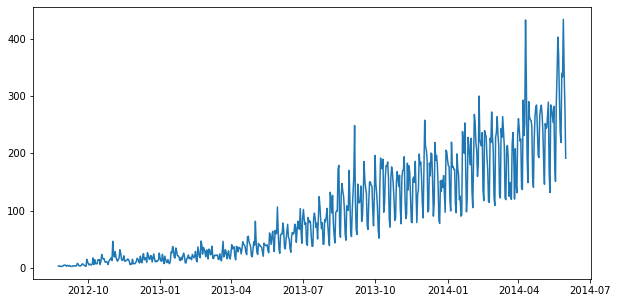

In [79]:
plt.plot(training['Count'], label='Train')

As we can see increasing trend in our plot, our series is not stationary

Let us also do Augmented Dickey-Fuller test to confirm

Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

- The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). 
- The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
\
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [80]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(training.Count,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %s' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.459335
p-value: 0.9973677028404562
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [81]:
result

(1.4593345842286929,
 0.9973677028404562,
 20,
 624,
 {'1%': -3.440873084361836,
  '5%': -2.866182929627575,
  '10%': -2.5692425987220577},
 5681.565932722825)

Our p value is greater than 0.05 therefore we fail to reject the null hypotheses, data is non stationary

#### Making the series stationary

In [82]:
# reference -https://towardsdatascience.com/achieving-stationarity-with-time-series-data-abd59fd8d5a0

In [83]:
train_log=np.log(training.Count)
train_log_movavg=train_log.rolling(24).mean()

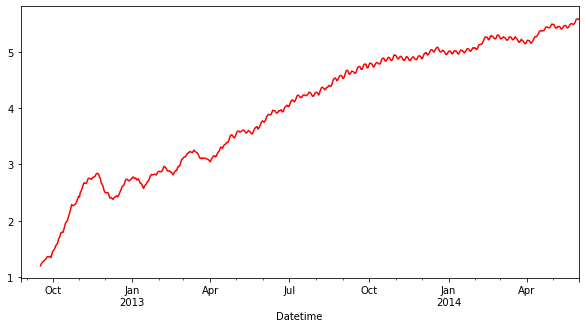

In [84]:
train_log_movavg.plot(color="red")

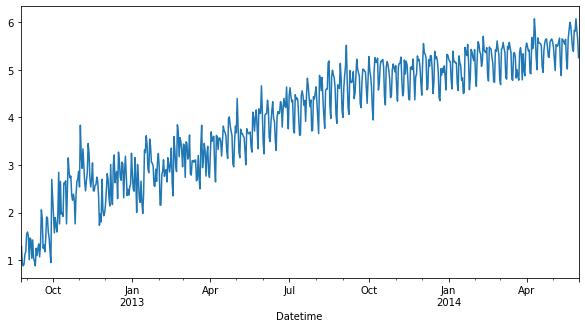

In [85]:
train_log.plot()

In [86]:
train_log_movavg_diff=train_log-train_log_movavg

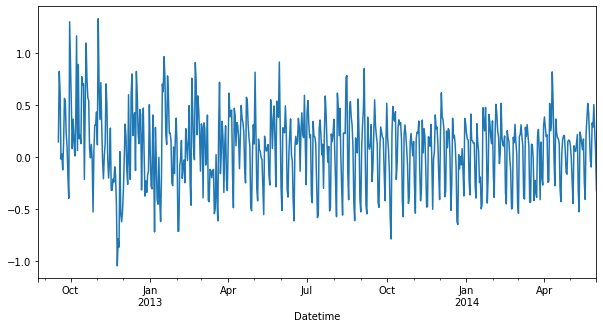

In [87]:
train_log_movavg_diff.plot()

In [88]:
# Since we took the average of 24 values, rolling mean is not defined for the first 23 values.
# So let’s drop those null values.

train_log_movavg_diff.dropna(inplace=True)

In [89]:
#again check stationarity
result = adfuller(train_log_movavg_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %s' % result[1])
print ('number of lags used: %s' %result[2])
print ('number of observations used: %s' %result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.786711
p-value: 2.4217878575859476e-09
number of lags used: 16
number of observations used: 605
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [90]:
# another method
# This is the process subtracting the value of one observation with the value of 
#another observation x number of periods ago, where x is the time period lag.

train_log_diff = train_log.diff(periods=1)

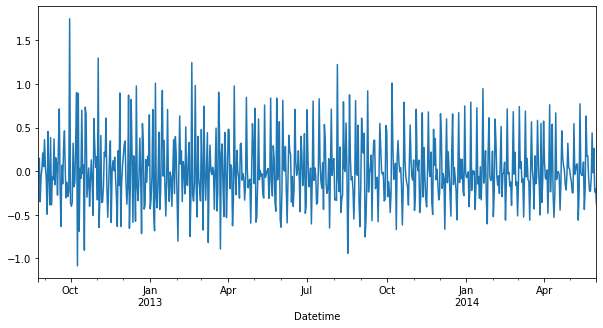

In [91]:
train_log_diff.plot()

In [92]:
result = adfuller(train_log_diff.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %s' % result[1])
print ('number of lags used: %s' %result[2])
print ('number of observations used: %s' %result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.113746
p-value: 1.2063926079682768e-12
number of lags used: 19
number of observations used: 624
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


Given the very low p value, train_log_diff is very stationary than train_log_movavg_diff

In [93]:
train_log_diff.dropna(inplace=True)

In [94]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

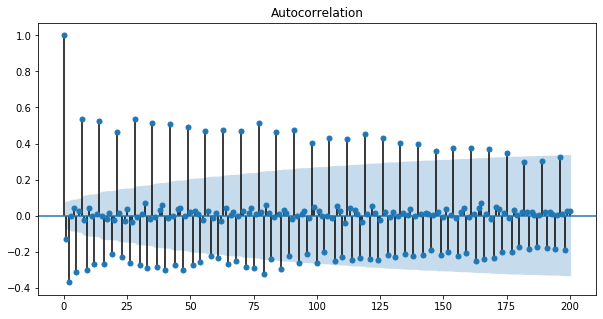

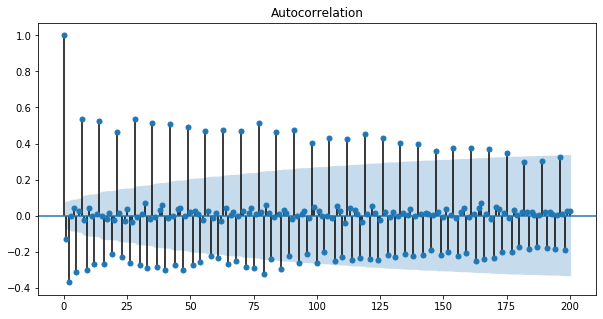

In [95]:
plot_acf(train_log_diff,lags=200)

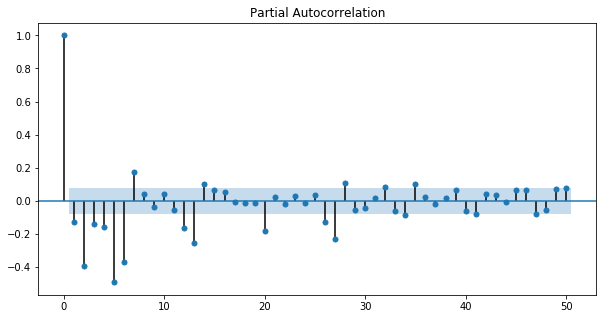

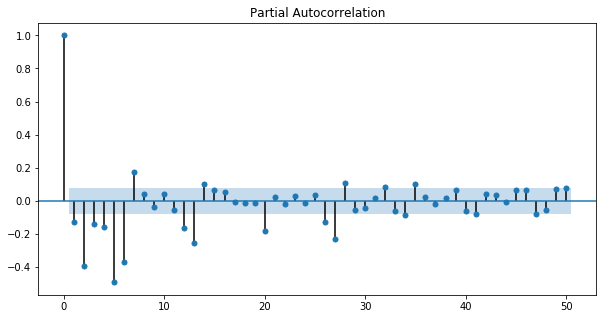

In [96]:
plot_pacf(train_log_diff,lags=50)

#### FORECASTING

In [97]:
#reference -https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8

In [98]:
from statsmodels.tsa.stattools import acf, pacf

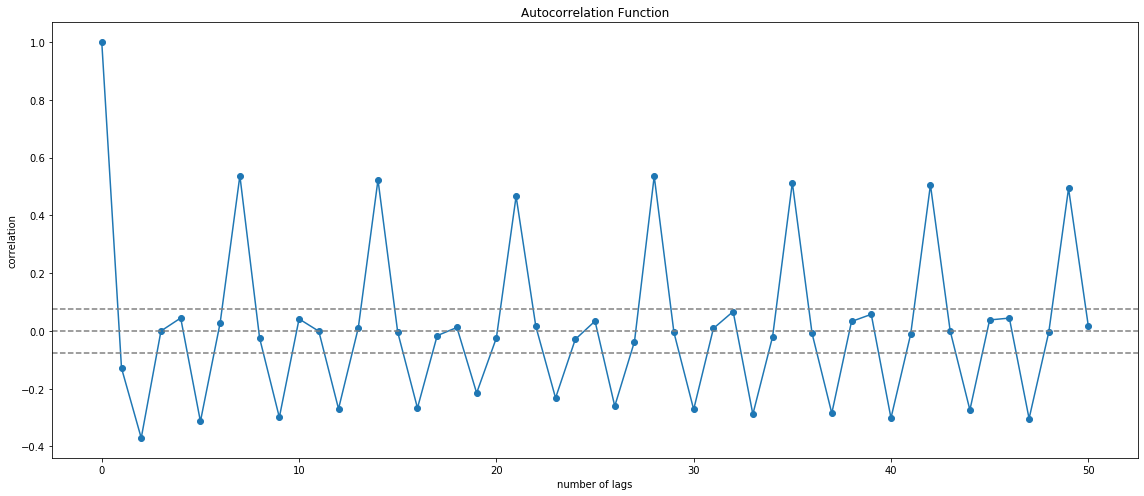

In [99]:
lag_acf = acf(pd.DataFrame(train_log_diff).Count.values, nlags=50)
plt.figure(figsize=(16, 7))
#Plot ACF(MA term, q)
# here 1.96 is the z value at 95% confidence
plt.plot(lag_acf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

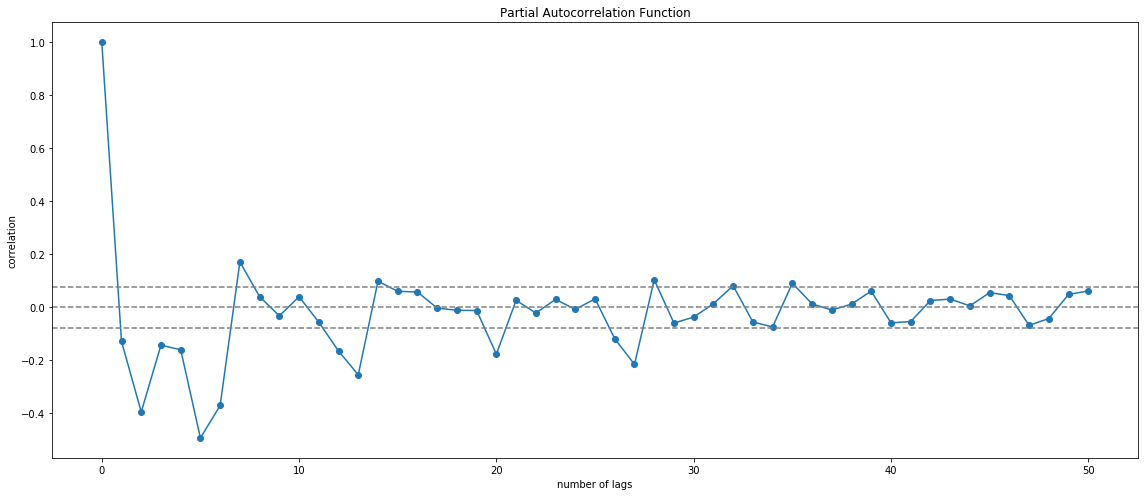

In [100]:
lag_pacf = pacf(pd.DataFrame(train_log_diff).Count.values, nlags=50, method='ols')

#PLOT PACF(AR term , p)
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=1.

q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=1.

In [101]:
from statsmodels.tsa.arima_model import ARIMA

import itertools
p=d=q=range(0,3)
pdq = list(itertools.product(p,d,q))

for order in pdq:
    try:
        arima = ARIMA(train_log_diff, order=order).fit()
        print(order,arima.aic)
    except:
        continue

(0, 0, 0) 624.4687435944836
(0, 0, 1) 513.2621850487924
(0, 0, 2) 389.00858479781755
(0, 1, 0) 1147.470235511734
(0, 1, 1) 632.9004050396966
(0, 1, 2) 523.446849510631
(0, 2, 0) 1803.9168405777175
(0, 2, 1) 1155.1566054758127
(0, 2, 2) 648.4976183204806
(1, 0, 0) 615.7351677284728
(1, 0, 1) 433.91835206441374
(1, 0, 2) 390.9300289240671
(1, 1, 0) 1041.9838134108202
(1, 2, 0) 1581.8861585416143
(2, 0, 0) 509.11432372626655
(2, 0, 1) 383.1995526693829
(2, 0, 2) 383.453846598238
(2, 1, 0) 856.3507980620686
(2, 1, 2) 392.8612526698778
(2, 2, 0) 1332.3623938033065


The optimal value of p, d, q is 2, 0, 1

In [102]:
train_log_diff

Datetime
2012-08-26    0.146603
2012-08-27   -0.350202
2012-08-28   -0.066691
2012-08-29    0.033902
2012-08-30    0.209721
                ...   
2014-05-27   -0.017336
2014-05-28    0.262576
2014-05-29   -0.238389
2014-05-30   -0.199290
2014-05-31   -0.380772
Freq: D, Name: Count, Length: 644, dtype: float64

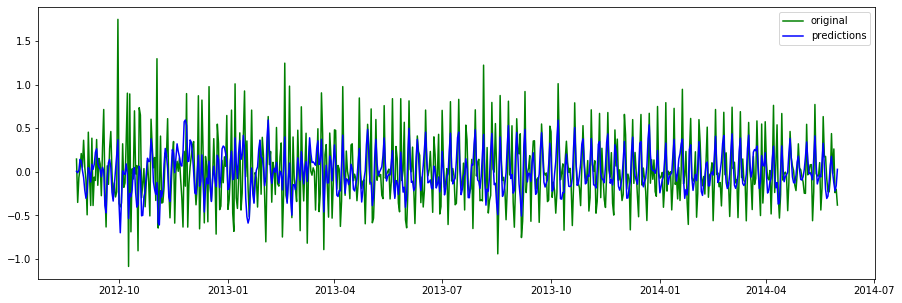

383.1995526693829

In [103]:
a= ARIMA(train_log_diff, order=(2,0,1))
arima= a.fit(disp=-1)

plt.figure(figsize=(15,5))
plt.plot(train_log_diff.dropna(), color="green",label='original') 
plt.plot(arima.fittedvalues, color='blue', label='predictions') 
plt.legend(loc='best') 
plt.show()
arima.aic

In [104]:
#showing how cumcum and shift will bring back the scaled predictions to original values

In [105]:
train_log[0]

1.1526795099383853

In [106]:
train_log

Datetime
2012-08-25    1.152680
2012-08-26    1.299283
2012-08-27    0.949081
2012-08-28    0.882389
2012-08-29    0.916291
                ...   
2014-05-27    5.809893
2014-05-28    6.072468
2014-05-29    5.834079
2014-05-30    5.634790
2014-05-31    5.254017
Freq: D, Name: Count, Length: 645, dtype: float64

In [107]:
train_log_diff

Datetime
2012-08-26    0.146603
2012-08-27   -0.350202
2012-08-28   -0.066691
2012-08-29    0.033902
2012-08-30    0.209721
                ...   
2014-05-27   -0.017336
2014-05-28    0.262576
2014-05-29   -0.238389
2014-05-30   -0.199290
2014-05-31   -0.380772
Freq: D, Name: Count, Length: 644, dtype: float64

In [108]:
train_log_diff.cumsum().shift().fillna(0)+train_log[0]

Datetime
2012-08-26    1.152680
2012-08-27    1.299283
2012-08-28    0.949081
2012-08-29    0.882389
2012-08-30    0.916291
                ...   
2014-05-27    5.827228
2014-05-28    5.809893
2014-05-29    6.072468
2014-05-30    5.834079
2014-05-31    5.634790
Freq: D, Name: Count, Length: 644, dtype: float64

In [109]:
# actual predictions
arima.predict(start="2014-06-01", end="2014-09-25")

2014-06-01    0.262604
2014-06-02    0.233414
2014-06-03    0.026641
2014-06-04   -0.052931
2014-06-05   -0.024501
                ...   
2014-09-21    0.007056
2014-09-22    0.007056
2014-09-23    0.007056
2014-09-24    0.007056
2014-09-25    0.007056
Freq: D, Length: 117, dtype: float64

In [110]:
arima.predict(start="2014-06-01", end="2014-09-25").cumsum().shift().fillna(0)

2014-06-01    0.000000
2014-06-02    0.262604
2014-06-03    0.496018
2014-06-04    0.522659
2014-06-05    0.469728
                ...   
2014-09-21    1.216385
2014-09-22    1.223441
2014-09-23    1.230497
2014-09-24    1.237553
2014-09-25    1.244609
Freq: D, Length: 117, dtype: float64

In [111]:
pd.Series(np.ones(validation.shape[0])*np.log(validation['Count'][0]), index= validation.index) 

Datetime
2014-06-01    5.402677
2014-06-02    5.402677
2014-06-03    5.402677
2014-06-04    5.402677
2014-06-05    5.402677
                ...   
2014-09-21    5.402677
2014-09-22    5.402677
2014-09-23    5.402677
2014-09-24    5.402677
2014-09-25    5.402677
Freq: D, Length: 117, dtype: float64

In [112]:
arima.predict(start="2014-06-01", end="2014-09-25").cumsum().shift().fillna(0)+pd.Series(np.ones(validation.shape[0])*np.log(validation['Count'][0]), index= validation.index) 

2014-06-01    5.402677
2014-06-02    5.665282
2014-06-03    5.898695
2014-06-04    5.925336
2014-06-05    5.872405
                ...   
2014-09-21    6.619063
2014-09-22    6.626119
2014-09-23    6.633174
2014-09-24    6.640230
2014-09-25    6.647286
Freq: D, Length: 117, dtype: float64

In [113]:
final_values=np.exp(arima.predict(start="2014-06-01", end="2014-09-25").cumsum().shift().fillna(0)+pd.Series(np.ones(validation.shape[0])*np.log(validation['Count'][0]), index= validation.index) )

In [114]:
final_values

2014-06-01    222.000000
2014-06-02    288.669245
2014-06-03    364.561452
2014-06-04    374.404207
2014-06-05    355.102061
                 ...    
2014-09-21    749.242543
2014-09-22    754.547745
2014-09-23    759.890511
2014-09-24    765.271109
2014-09-25    770.689805
Freq: D, Length: 117, dtype: float64

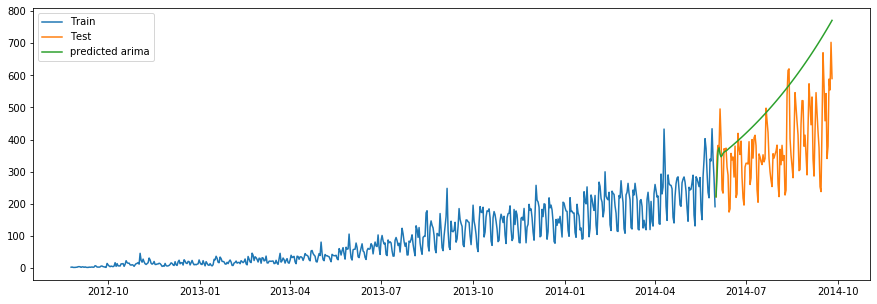

In [115]:
plt.figure(figsize=(15,5))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Test')
plt.plot(final_values, label='predicted arima')
plt.legend(loc='best')
plt.show()

In [116]:
rmse=np.sqrt(mean_squared_error(validation.Count,final_values))
rmse

189.48808399409657

In [117]:
len(final_values)

117

In [118]:
# But first we have to change scale and then convert it to hourly
#this can be done as demonstrated already

### 5. SARIMA

What’s Wrong with ARIMA
Autoregressive Integrated Moving Average, or ARIMA, is a forecasting method for univariate time series data.

As its name suggests, it supports both an autoregressive and moving average elements. The integrated element refers to differencing allowing the method to support time series data with a trend.

A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle.

ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

Trend Elements\
There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:
\
p: Trend autoregression order.\
d: Trend difference order.\
q: Trend moving average order.\
\
Seasonal Elements\
There are four seasonal elements that are not part of ARIMA that must be configured; they are:
\
P: Seasonal autoregressive order.\
D: Seasonal difference order.\
Q: Seasonal moving average order.\
m: The number of time steps for a single seasonal period.

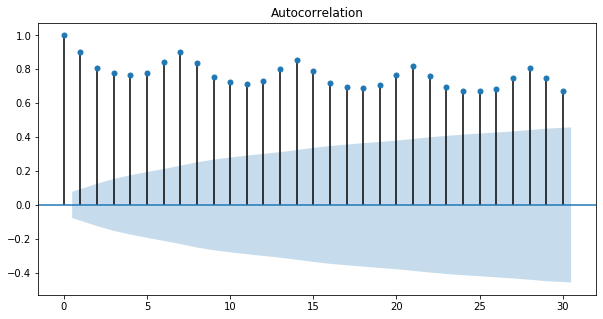

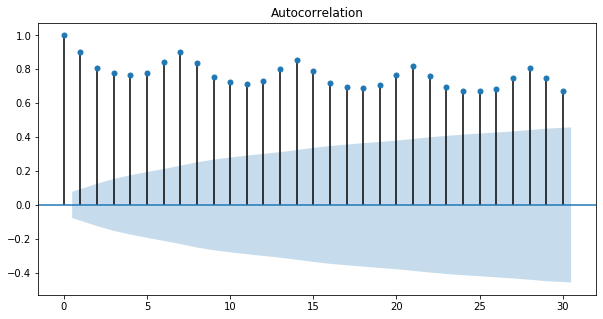

In [119]:
plot_acf(training.Count,lags=30)

In [120]:
training

,Count,year,month,day,hour,dow,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0
...,...,...,...,...,...,...,...
2014-05-27,333.583333,2014.0,5.0,27.0,11.5,1.0,0.0
2014-05-28,433.750000,2014.0,5.0,28.0,11.5,2.0,0.0
2014-05-29,341.750000,2014.0,5.0,29.0,11.5,3.0,0.0


In [121]:
fit1 = SARIMAX(training.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
forcast1=fit1.predict(start="2014-6-01", end="2014-9-25", dynamic=True)

In [122]:
rmse=np.sqrt(mean_squared_error(validation.Count, forcast1))
rmse

65.73884225250906

In [123]:
def optimum_model(inp,output):
    p_params = [0, 1, 2,3]
    d_params = [1]
    q_params = [0, 1, 2,3]
  
    P_params = [0, 1, 2,3]
    D_params = [1]
    Q_params = [0, 1, 2,3]
    rmsed=float('inf')
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:

                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            try:
                                fitt=SARIMAX(inp, order=(p,d,q),seasonal_order=(P,D,Q,7)).fit()
                                forecast=fitt.predict(start="2014-6-01", end="2014-9-25", dynamic=True)
                                print (np.sqrt(mean_squared_error(output, forecast)),p,d,q)
                                if np.sqrt(mean_squared_error(output, forecast))<rmsed:
                                    rmsed=np.sqrt(mean_squared_error(output, forecast))
                                    optimum_values=(p,d,q,P,D,Q)
                            except:
                                continue
    print ("MOST OPTIMUM VALUES ARE")
    return optimum_values


In [125]:
#optimum_model(training.Count,validation.Count)

542.760595623838 0 1 0
117.82640945839914 0 1 0
128.18962220559297 0 1 0
124.97166644922959 0 1 0
267.7531905538244 0 1 0
126.68793911323576 0 1 0
127.56641419583052 0 1 0
110.97233062059401 0 1 0
179.7526489126828 0 1 0
126.91816074155273 0 1 0
110.51589852614323 0 1 0
121.1394933626297 0 1 0
169.58732141090738 0 1 0
130.27612430315463 0 1 0
129.54585829257243 0 1 0
130.373415192711 0 1 0
324.73008838744477 0 1 1
65.98238123907798 0 1 1
66.93643290120936 0 1 1
66.58795088040358 0 1 1
69.81322339866885 0 1 1
66.8129008058212 0 1 1
66.98121157800442 0 1 1
66.8137612013707 0 1 1
68.72050044037944 0 1 1
67.14649216437846 0 1 1
66.21154819206271 0 1 1
71.06141296058944 0 1 1
64.96208173975317 0 1 1
66.93427308901106 0 1 1
67.02262752594345 0 1 1
66.89975403491732 0 1 1
84.3704241538243 0 1 2
65.53545152126335 0 1 2
66.3573446294636 0 1 2
66.04250917695805 0 1 2
72.96326435532966 0 1 2
66.14475361829955 0 1 2
66.32743711745863 0 1 2
66.79297989320139 0 1 2
70.42788338188683 0 1 2
66.3750119

(0, 1, 1, 3, 1, 0)

In [ ]:
# MOST OPTIMUM VALUES ARE (0, 1, 1, 3, 1, 0)

In [126]:
fit1 = SARIMAX(training.Count, order=(0,1,1),seasonal_order=(3,1,0,7)).fit() 
forcast1=fit1.predict(start="2014-6-01", end="2014-9-25", dynamic=True)

rmse=np.sqrt(mean_squared_error(validation.Count, forcast1))
rmse

64.96208173975317

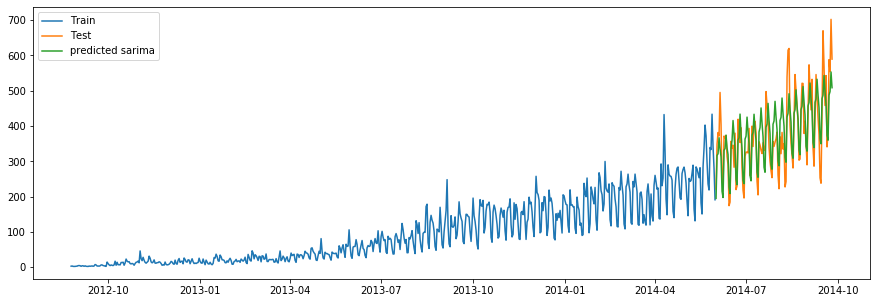

In [128]:
plt.figure(figsize=(15,5))
plt.plot(training['Count'], label='Train')
plt.plot(validation['Count'], label='Test')
plt.plot(forcast1, label='predicted sarima')
plt.legend(loc='best')
plt.show()

In [129]:
#convert it to hourly
#this can be done as demonstrated already

### 6. AUTO ARIMA

In [139]:
from pmdarima.arima import auto_arima

stepwise_model = auto_arima(training.Count, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,random_state=20,n_fits=30)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,7) [intercept=True]; AIC=5719.986, BIC=5742.270, Time=2.926 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=True]; AIC=6172.297, BIC=6181.210, Time=0.620 seconds
Fit ARIMA(1,1,0)x(1,1,0,7) [intercept=True]; AIC=6023.318, BIC=6041.145, Time=1.069 seconds
Fit ARIMA(0,1,1)x(0,1,1,7) [intercept=True]; AIC=5785.650, BIC=5803.477, Time=0.953 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=False]; AIC=6170.300, BIC=6174.757, Time=0.040 seconds
Fit ARIMA(1,1,1)x(0,1,0,7) [intercept=True]; AIC=5970.652, BIC=5988.479, Time=1.949 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,7) [intercept=True]; AIC=5715.637, BIC=5742.378, Time=5.325 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.9

In [140]:
stepwise_model

ARIMA(order=(1, 1, 2), seasonal_order=(2, 1, 1, 7), suppress_warnings=True)

In [141]:
aarima=stepwise_model.fit(training.Count)

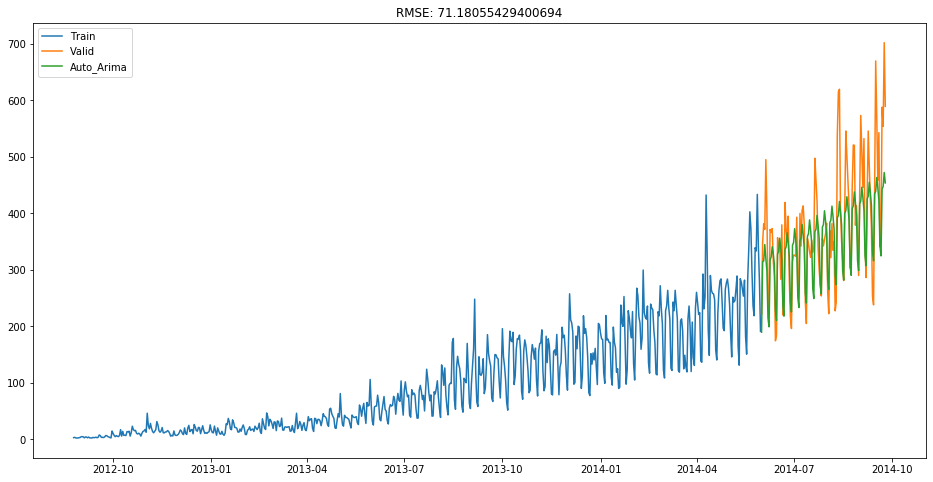

In [142]:

forecast = aarima.predict(n_periods=len(validation))
forecast = pd.DataFrame(forecast,index = validation.index, columns=['Prediction'])
# y_hat_avg= pd.concat([validation['Count'],forecast['Prediction']])
plt.figure(figsize=(16,8)) 
plt.plot( training['Count'], label='Train') 
plt.plot(validation['Count'], label='Valid') 
plt.plot(forecast['Prediction'], label='Auto_Arima') 
plt.legend(loc='best') 
plt.show()

In [143]:
rmse=np.sqrt(mean_squared_error(validation.Count, forecast['Prediction']))
rmse

71.18055429400694